In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from joblib import load

In [2]:
problems = ['claim-approval', 'pa-approval', 'reject-code']
models = ['logistic-regression', 'decision-tree', 'random-forest']
scores = ['recall', 'roc-auc', 'precision', 'accuracy']

names = [model + '-' + problem for model in models for problem in problems]
pipes = {}
for name in names:
    pipes[name] = load('../models/saved-models/' + name + '.joblib')

In [3]:
test_X = {}
test_y = {}

claims_df = pd.read_csv('../data/processed/dim_claims_test.csv')
claims_df = claims_df.fillna(0)
claims_df.loc[:, 'reject_code'] = claims_df['reject_code'].astype(int)
pa_df = pd.read_csv('../data/processed/dim_pa_test.csv')
bridge_df = pd.read_csv('../data/processed/bridge_test.csv')

test_X['claim-approval'] = claims_df[['bin', 'drug']]
test_y['claim-approval'] = claims_df['pharmacy_claim_approved']

combined_df = bridge_df.merge(claims_df, on='dim_claim_id').merge(pa_df, on='dim_pa_id')
test_X['pa-approval'] = combined_df[['bin', 'drug', 'correct_diagnosis', 'tried_and_failed', 'contraindication']]
test_y['pa-approval'] = combined_df['pa_approved']

reject_df = claims_df.loc[claims_df['pharmacy_claim_approved'] == 0]
test_X['reject-code'] = reject_df[['bin', 'drug']]
test_y['reject-code'] = reject_df['reject_code']

In [4]:
accuracy = {}
recall = {}
precision = {}
roc_auc = {}

for name in names:
    for problem in problems:
        if problem not in name:
            continue
        if 'reject-code' in name:
            average = 'macro'
        else:
            average = 'binary'
        accuracy[name] = accuracy_score(test_y[problem], pipes[name].predict(test_X[problem]))
        precision[name] = precision_score(test_y[problem], pipes[name].predict(test_X[problem]), average=average)
        recall[name] = recall_score(test_y[problem], pipes[name].predict(test_X[problem]), average=average)
        if 'reject-code' in name:
            roc_auc[name] = roc_auc_score(test_y[problem], pipes[name].predict_proba(test_X[problem]), multi_class='ovo')
        else:
            roc_auc[name] = roc_auc_score(test_y[problem], pipes[name].predict_proba(test_X[problem])[:, 1])

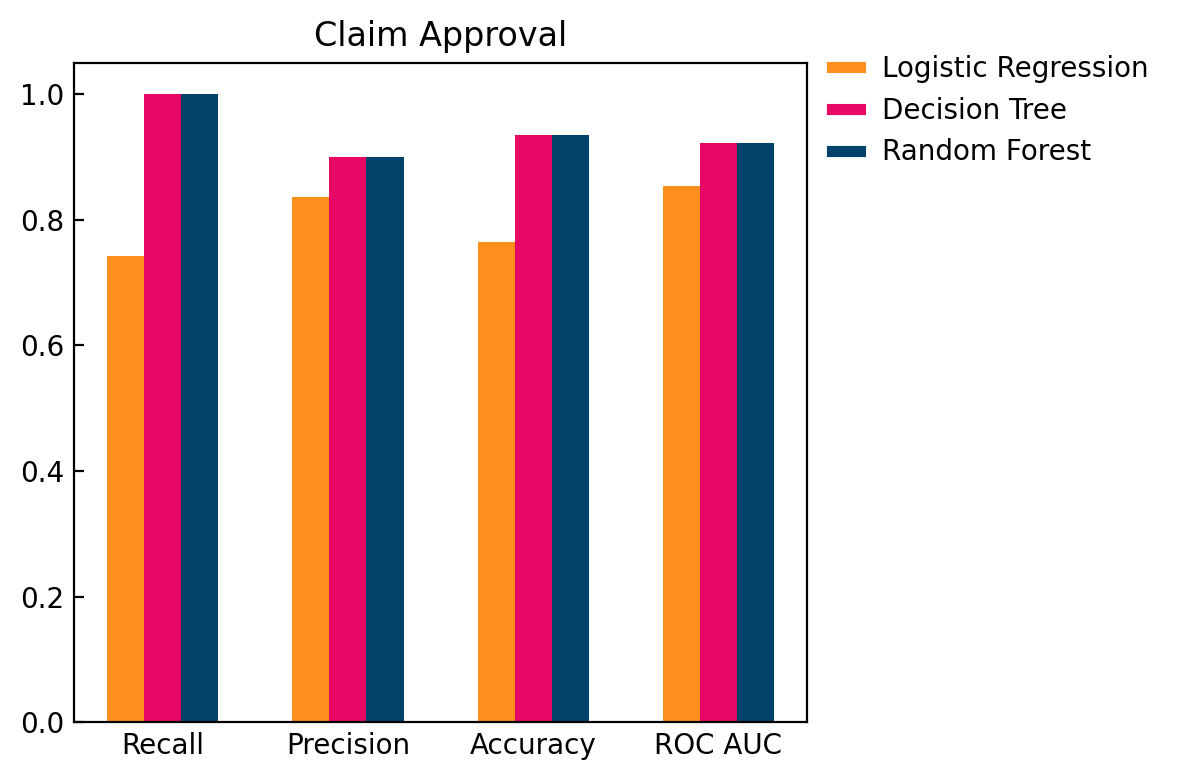

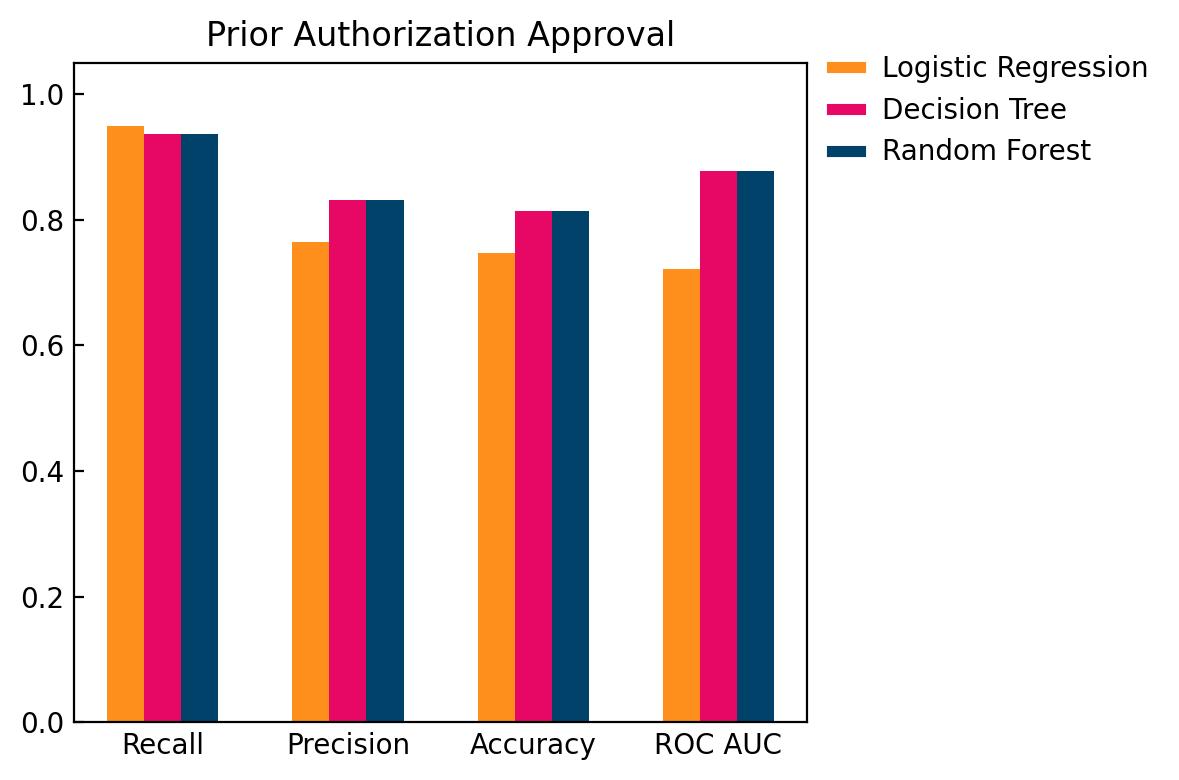

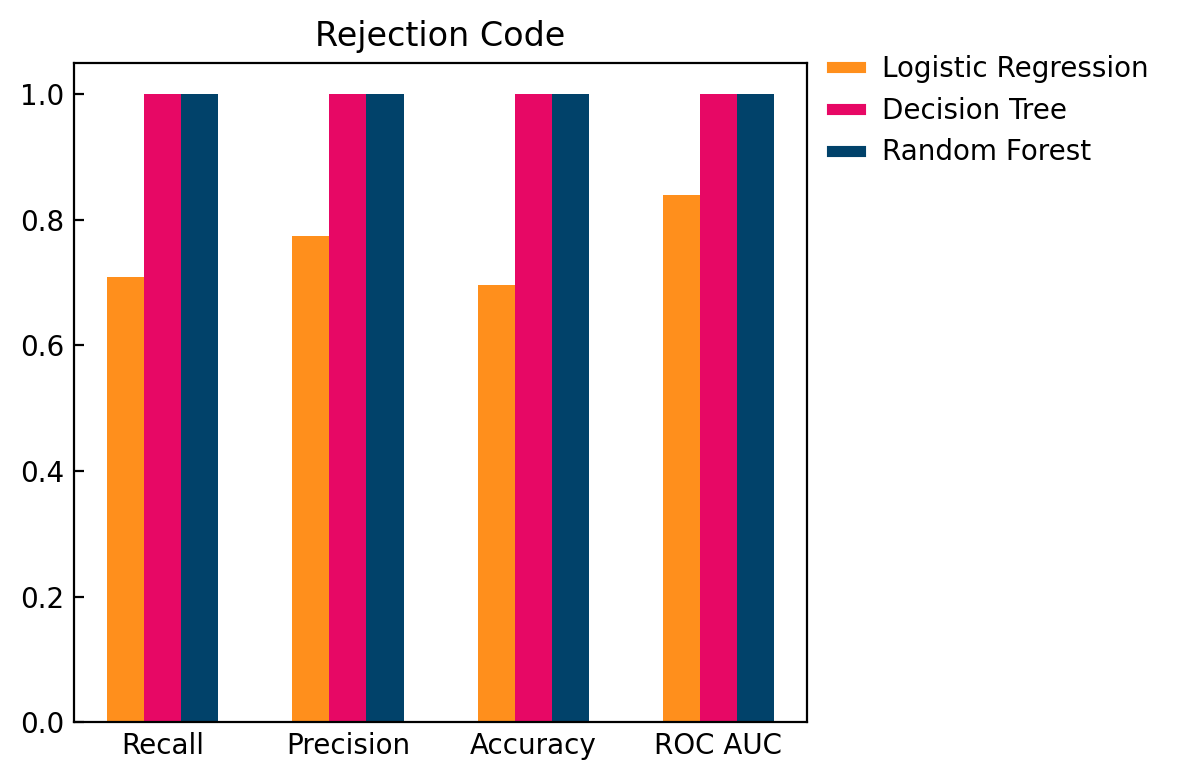

In [8]:
width = 0.2
colors = {'logistic-regression': '#FF8F1C', 
          'decision-tree': '#E70865', 
          'random-forest': '#01426A'}

fancy_model = {'logistic-regression': 'Logistic Regression',
               'decision-tree': 'Decision Tree',
               'random-forest': 'Random Forest'}

fancy_problem = {'pa-approval': 'Prior Authorization Approval',
                 'claim-approval': 'Claim Approval',
                 'reject-code': 'Rejection Code'}

for problem in problems:
    f, ax = plt.subplots(1, 1, dpi=200)
    ax.set_title(fancy_problem[problem])
    for name in names:
        if problem not in name:
            continue
        if 'logistic-regression' in name:
            position = -1
            model = 'logistic-regression'
        elif 'decision-tree' in name:
            position = 0
            model = 'decision-tree'
        elif 'random-forest' in name:
            position = 1
            model = 'random-forest'
        for i, score in enumerate([recall, precision, accuracy, roc_auc]):
                ax.bar(i + position * width, score[name], width=width, color=colors[model])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['Recall', 'Precision', 'Accuracy', 'ROC AUC'])
    ax.tick_params(direction='in', bottom=False)
    ax.set_ylim(0, 1.05)
    color_lines = [Line2D([0], [0], color=colors[model], lw=4) for model in models]
    ax.legend(color_lines, [fancy_model[model] for model in models], frameon=False, handlelength=1, loc='upper left', bbox_to_anchor=(1, 1.05))
    plt.tight_layout()
    plt.savefig('../models/saved-model-figures/' + problem + '.png')
    plt.show()